# Energy Consumption Exploratory Data Analysis

<a id='intro'></a>
## Introduction

In this project I took the data of the energy consumption in Spain of the two past years and I am going to do an Exploratory Data Analysis. The goal is to find trends in the energy consumption, like in which season or at which hour people consume more energy, or the evolution of the renewable and non renewable energies in Spain.

The ETL was previously done in Pandas and the tables I use have been uploaded via Google BigQuery. With that previous work done, in this document I can fully focus on the EDA and its conclusions.

In this project, there are three types of tables. The first one contains information about the energy demand. Other than date and hour, it contains three different columns with numerical values.
*  The real column contains the actual value of energy demand for each date and time.
*  The expected column is elaborated by REE directly. It contains the expected energy demand for every date and time and it's calculated with the values of the consumption of similar periods. It includes some corrections due to any factor that may affect the consumption, like the weather or economic activity.
*  The scheduled column contains the scheduled energy demand for every date and time. It's elaborated for those groups/actors that are involved in the energy production.

The second and third files contain information about the energy generation and CO2 emissions for every energy source. The types of energy source are divided into renewable sources and non renewable sources. These are the following ones:
*  Wind energy: contains the energy generated, or the CO2 emissions, of the wind energy.
*  Nuclear: contains the energy generated, or the CO2 emissions, of the nuclear energy.
*  Charcoal: contains the energy generated, or the CO2 emissions, of the charcoal energy.
*  Combined cycle: contains the energy generated, or the CO2 emissions, of the energy generated through the combined cycle. It's an energy generation process that combines two thermodinamic cycles in one system. In one of them, the working fluid is water steam and in the other one is gas. The heat generated is used to heat the gas and the steam and, after that, move the turbines, connected to an electric generator.
*  Hydropower energy: contains the energy generated, or the CO2 emissions, of the hydropower energy.
*  Photovoltaic solar: contains the energy generated, or the CO2 emissions, of the photovoltaic solar energy.
*  Thermal solar energy: contains the energy generated, or the CO2 emissions, of the thermal solar energy. This energy uses the solar radiation to create mechanic energy and, with it, electric energy.
*  Renewable thermal: contains the energy generated, or the CO2 emissions, of the thermal renewable energy. 
*  Diesel motors: contains the energy generated, or the CO2 emissions, of the energy created through diesel motors. 
*  Gas turbine: contains the energy generated, or the CO2 emissions, of the gas turbine energy. 
*  Steam turbine: contains the energy generated, or the CO2 emissions, of the steam turbine energy. 
*  Auxiliar generation: contains the energy generated, or the CO2 emissions, of the auxiliar generation energy. 
*  Cogeneration and residues: contains the energy generated, or the CO2 emissions, of the cogeneration and residues energy. Cogeneration is the generation of electric and thermal energy simultaneously. The solid urban residues are recycled and used as an energy source.

<a id='#eda'></a>
## Exploratory Data Analysis: Energy Demand

#### Import libraries

In [ ]:
# Import all the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly
import matplotlib.pyplot as plt

In [ ]:
# Import the GBQ project into python
from google.cloud import bigquery
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
'/content/drive/MyDrive/Data REE/energy-ree-project-282e3f1ab60e.json')

project_id = 'energy-ree-project'
client = bigquery.Client(credentials= credentials, project = project_id)

## Query 1

In [ ]:
query_job = """
SELECT
  date,
  CAST(hour AS string) AS hour,
  real,
  expected,
  scheduled,
  EXTRACT(month
  FROM
    date) AS month,
  CASE
    WHEN EXTRACT(month FROM date) < 4 THEN 'winter'
    WHEN EXTRACT(month
  FROM
    date) < 7 THEN 'spring'
    WHEN EXTRACT(month FROM date) < 10 THEN 'summer'
  ELSE
  'autumn'
END
  AS season,
  CASE
    WHEN date < '2021-08-01' THEN '20-21'
  ELSE
  '21-22'
END
  AS year
FROM
  `energy-ree-project.energy_generic_info.energy-demand-ree`
ORDER BY
  date,
  hour;"""

query1 = pd.read_gbq(query_job, project_id=project_id, credentials = credentials, dialect='standard')

In [ ]:
query1.head()

,date,hour,real,expected,scheduled,month,season,year
0,2020-08-01,00:00:00,31338,31577,31321,8,summer,20-21
1,2020-08-01,00:05:00,31622,31465,31321,8,summer,20-21
2,2020-08-01,00:10:00,31711,31348,31321,8,summer,20-21
3,2020-08-01,00:15:00,31645,31224,31321,8,summer,20-21
4,2020-08-01,00:20:00,31471,31096,31321,8,summer,20-21


This query shows the energy demand on Spain with a granularity by hour, day, month, season and year. The three numeric columns shown are 'real', 'expected' and 'scheduled'.

I will answer the following questions regarding the energy demand in Spain:

* How is the evolution of the demand through the years? And through the day?
* Does there exist a trend in the behavior between the years 20-21 and 21-22?
* Which month of the year has the highest consumption? Does the consumption trend change over the seasons?
* Does a correlation exist between the real demand and the expected one? Check by month and hour. Compare both years.
* Which ones are the days with higher consumption than the average? Is there any relationship among them?


The next questions will be answered with the resulting table of the first query. Therefore, I'll do a little previous analysis of this query.

In [ ]:
# Check how many columns and attributes the data set has
query1.shape

(210216, 8)

In [ ]:
# Checking the name of the columns
query1.columns

Index(['date', 'hour', 'real', 'expected', 'scheduled', 'month', 'season',
       'year'],
      dtype='object')

In [ ]:
# It's possible to see similar values on 'Real', 'Expected' and 'Scheduled' variable
query1.describe()

,real,expected,scheduled,month
count,210216.000000,210216.000000,210216.000000,210216.00000
mean,29332.853969,29301.900479,29286.977380,6.52643
std,4561.538117,4556.146356,4571.183078,3.44785
min,18433.000000,18435.000000,18320.000000,1.00000
25%,25494.000000,25460.750000,25470.000000,4.00000
50%,29671.000000,29646.000000,29646.000000,7.00000
75%,32823.000000,32790.000000,32803.250000,10.00000
max,44153.000000,43956.000000,43711.000000,12.00000


In [ ]:
# Since the data was previously cleaned, there are no missing values
query1.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210216 entries, 0 to 210215
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       210216 non-null  dbdate
 1   hour       210216 non-null  object
 2   real       210216 non-null  Int64 
 3   expected   210216 non-null  Int64 
 4   scheduled  210216 non-null  Int64 
 5   month      210216 non-null  Int64 
 6   season     210216 non-null  object
 7   year       210216 non-null  object
dtypes: Int64(4), dbdate(1), object(3)
memory usage: 13.6+ MB


In [ ]:
# Switch the date column into datetime
query1['date'] = query1['date'].astype('datetime64[ns]')

## How is the evolution of the demand through the years? And through the day?

In [ ]:
# Group by date to see the data of every day
gbdate = query1.groupby(by = "date").sum() 
gbdate.drop("month",axis = 1, inplace = True)
gbdate.sort_values(by = "date", inplace = True)

[Text(0.5, 1.0, 'Energy demand over day')]

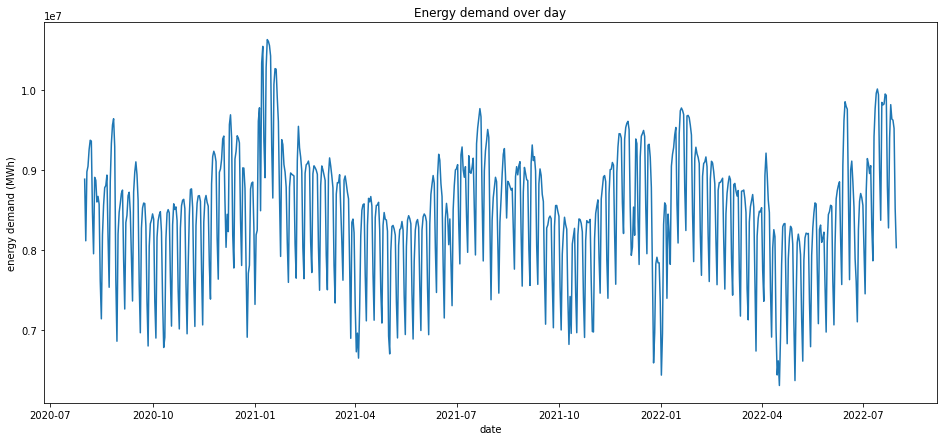

In [ ]:
# Plot the data
fig_dims = (16,7)
fig, ax = plt.subplots(figsize = fig_dims)
ax.set(xlabel='date', ylabel='energy demand (MWh)')
sns.lineplot(data = gbdate, x = "date", y = "real").set(title='Energy demand over day')

As we can see in the graphic, the energy demand goes constantly up and down. It could be a good thing to explore why.
For this, we extract the data from January 2021 to July 2021 and the days that have a demand lower than 7.5x10^6.

In [ ]:
gbdate = gbdate.reset_index()
gbdate.head()

,date,real,expected,scheduled
0,2020-08-01,8886255,8862457,8872416
1,2020-08-02,8114228,8107194,8093604
2,2020-08-03,8978265,8981649,8974428
3,2020-08-04,9048086,9018401,9025632
4,2020-08-05,9256489,9227962,9221856


In [ ]:
# Try to find the date of those negative crests
gbdate['date'] = gbdate['date'].astype('datetime64[ns]')
gbdate_peaks = gbdate[(gbdate["real"] < 7500000) & (gbdate["date"] > '2021-01-01') & (gbdate["date"] < '2021-07-31')]

# Extract the day of the week of that period
gbdate_peaks["weekday"] = gbdate_peaks["date"].dt.dayofweek

# Group by the day of the week
dayweek = gbdate_peaks.groupby(by = "weekday").count()
dayweek = dayweek.filter(["weekday","real"])
dayweek.sort_values(by = "weekday", inplace = True)

# Calculate the percentage of every day of the week for those circumstances
dayweek["percentage"] = round((dayweek["real"]*100/dayweek["real"].sum()),2)
dayweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,real,percentage
weekday,,
0,1,4.0
3,1,4.0
4,1,4.0
5,6,24.0
6,16,64.0


We see that a 64% of the days are Sundays and a 24% of the days are Saturdays. That means that the 88% of the low crests are on weekend. Eitherway, those negative crests make very difficult the visualization of the data. Therefore, I'll be doing a rolling average to have a better data visualization.

To reinforce this hypothesis, I will group the demand by the day of the week and see the percentage of the demand for each day of the week.

In [ ]:
gbdate = query1.groupby('date').sum()
gbdate = gbdate.reset_index()
gbdate['weekday'] = gbdate['date'].dt.dayofweek
gbdate = gbdate.drop(['date','expected','scheduled','month'], axis = 1)
gbdate = gbdate.groupby('weekday').sum()
gbdate["percentage"] = round((gbdate["real"]*100/gbdate["real"].sum()),2)
gbdate

,real,percentage
weekday,,
0,892153826,14.47
1,917382087,14.88
2,921105079,14.94
3,918577861,14.9
4,907593286,14.72
5,832270573,13.5
6,777152518,12.6


From Monday to Friday, each one of these days almost 15% of the energy was consumed. On Saturdays, 13.5% of the energy was consumed and, on Sunday, 12.6%.
These values, although don't seem very different, cause enough disturbance to create those negative crests.

In [ ]:
# Use the rolling average to have a better visualization
gbdate = query1.groupby('date').sum()
rolling_avg = gbdate.rolling(7).mean()
rolling_avg = rolling_avg[rolling_avg["real"].notnull()]
rolling_avg.head()

,real,expected,scheduled,month
date,,,,
2020-08-07,9.003128e+06,8.986121e+06,8.983116e+06,2304.0
2020-08-08,8.944521e+06,8.931715e+06,8.922417e+06,2304.0
2020-08-09,8.921314e+06,8.906930e+06,8.894321e+06,2304.0
2020-08-10,8.911482e+06,8.896827e+06,8.884622e+06,2304.0
2020-08-11,8.886475e+06,8.876141e+06,8.860718e+06,2304.0


[Text(0.5, 1.0, 'Energy demand over day')]

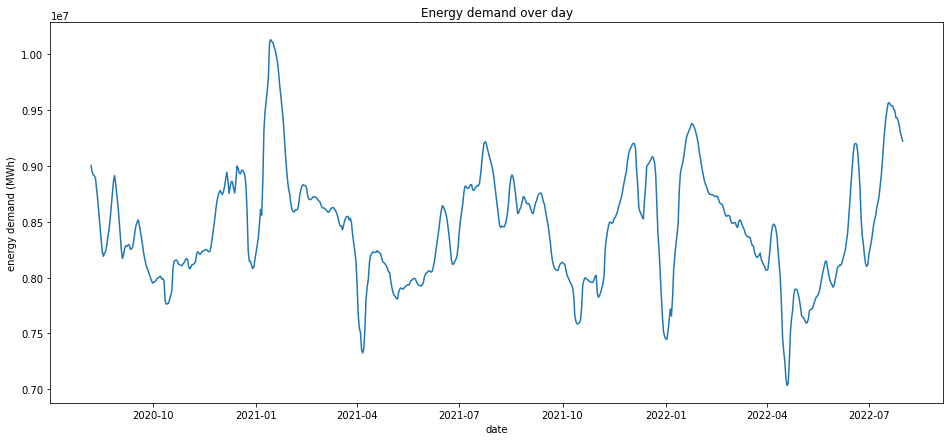

In [ ]:
# Plot of the data
fig_dims = (16,7)
fig, ax = plt.subplots(figsize = fig_dims)
ax.set(xlabel='date', ylabel='energy demand (MWh)')
sns.lineplot(data = rolling_avg, x = "date", y = "real").set(title='Energy demand over day')

In [ ]:
# Guess that maximum peak on the average roll lineplot
rolling_avg = rolling_avg[rolling_avg['real'] == rolling_avg['real'].max()]
rolling_avg = rolling_avg.reset_index()
rolling_avg

,date,real,expected,scheduled,month
0,2021-01-14,1.013100e+07,1.011223e+07,1.009331e+07,288.0


With these modifications, we see there is a trend in the energy demand. In both years, the months with less demand are October, November, April, May and June. The big peak is January 14th 2021.
https://www.elcorreo.com/economia/tu-economia/subida-afecta-20210114122658-nt.html
This link shows the news from January14th 2021, where there was an increase in the price of the electric energy.

Now I'll proceed with the data visualization by hour

In [ ]:
# Group the information by the hour of the day
gbhour = query1.groupby(by = "hour").sum()
gbhour.drop("month", axis = 1, inplace = True)
gbhour.sort_values(by = "hour", inplace = True)
gbhour = gbhour.reset_index()

# Extract the hour for each time
gbhour['hour'] = gbhour['hour'].astype(str)
gbhour[['time', 'min','sec']] = gbhour['hour'].str.split(':', expand=True)
gbhour.drop(['hour','min','sec'], axis = 1, inplace = True)
gbhour = gbhour.groupby('time').sum()

[Text(0.5, 1.0, 'Energy demand over the day')]

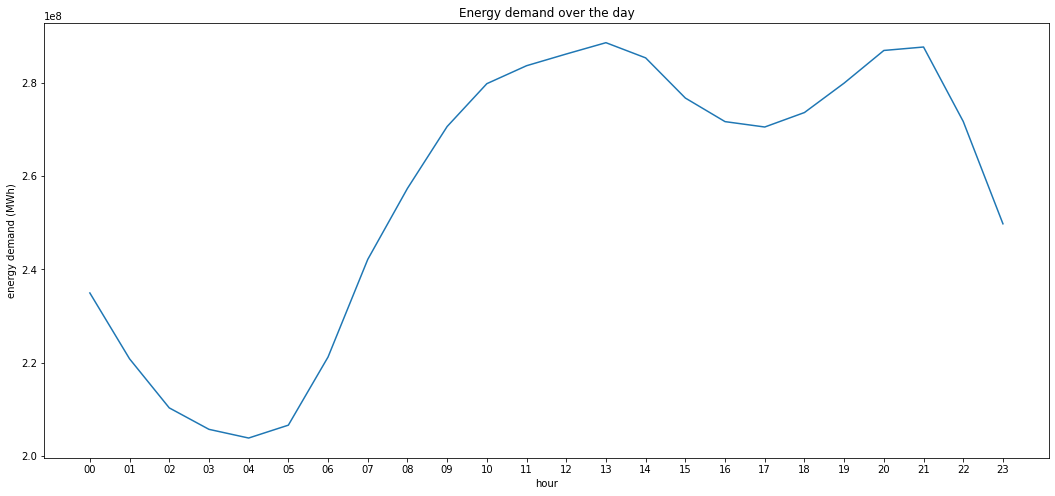

In [ ]:
# Plotting lineplot of 'real' demand over time
fig_dims = (18,8)
fig, ax = plt.subplots(figsize = fig_dims)
ax.set(xlabel='hour', ylabel='energy demand (MWh)')
sns.lineplot(data = gbhour, x = "time", y = "real").set(title='Energy demand over the day')

We can see that the energy demand starts increasing at 5:00. Other than that, we can see a minimum value at 4:00, when everyone is sleeping. The highest values can be found at 13:00, 20:00 and 21:00, at lunchtime and dinnertime.
Since this graphic has a precision of hours, it could be interesting finding those values with minutes.

In [ ]:
# Extract the values of the positive peaks
gbhour = query1.groupby('hour').sum()
pospeaks = gbhour[gbhour["real"] > 24100000]
pospeaks = pospeaks.reset_index()
pospeaks

,hour,real,expected,scheduled,month
0,13:25:00,24101198,24047257,24001518,4764
1,13:35:00,24102235,24047407,24004300,4764
2,13:40:00,24104235,24040503,24004300,4764
3,20:50:00,24112349,24055125,23923822,4764
4,20:55:00,24144713,24078957,23923822,4764
5,21:00:00,24107562,24098313,23958666,4764
6,21:05:00,24117492,24111156,23958666,4764
7,21:10:00,24166516,24112299,23958666,4764
8,21:15:00,24170363,24101764,23958742,4764
9,21:20:00,24180677,24079007,23958742,4764


The positive peaks are around 13:30 and around 21:00, when we have lunch and dinner.

In [ ]:
maximum_peak = gbhour[gbhour["real"] == gbhour["real"].max()]
maximum_peak = maximum_peak.reset_index()
maximum_peak

,hour,real,expected,scheduled,month
0,21:20:00,24180677,24079007,23958742,4764


In [ ]:
# Do the same with the negative crest
negative_crest = gbhour[gbhour["real"] < 17000000]
negative_crest = negative_crest.reset_index()
negative_crest 

,hour,real,expected,scheduled,month
0,04:00:00,16972958,17003610,16911606,4764
1,04:15:00,16975116,16976734,16908659,4764
2,04:20:00,16994408,16970586,16908659,4764
3,04:25:00,16982071,16965529,16908659,4764
4,04:30:00,16951622,16961564,16907687,4764
5,04:35:00,16986475,16959432,16907687,4764
6,04:40:00,16984303,16959860,16907687,4764
7,04:45:00,16958063,16962847,16907209,4764
8,04:50:00,16986601,16966370,16907209,4764
9,04:55:00,16996970,16968364,16907209,4764


The negative crest is around 4:30, when everyone is sleeping.

In [ ]:
minimum_crest = gbhour[gbhour["real"] == gbhour["real"].min()]
minimum_crest

,real,expected,scheduled,month
hour,,,,
04:30:00,16951622,16961564,16907687,4764


## Does exist a trend in the behaviour between the year 20-21 and 21-22?

In [ ]:
# Create one dataframe for each year and check if both have the same number of rows, they should
query1_2021 = query1[query1["year"] == '20-21']

# Group by date on both dataframes
query1_2021 = query1_2021.groupby(by = ["date"]).sum()
query1_2122 = query1[query1["year"] == '21-22']
query1_2122 = query1_2122.groupby(by = ["date"]).sum()

# Check both datasets have the same length
query1_2021.shape[0] == query1_2122.shape[0]

True

In [ ]:
# Create a dataframe with the information of both years
query_years = query1_2021.filter(["date","real"])

# Filter by the columns I am interested in and I change the name to the name of the year
query_years = query_years.rename(columns = {"real":"20-21"})
query_years = query_years.reset_index()
real2122 = list(query1_2122["real"])

# Create a new column with the data of the year 22-23
query_years["21-22"] = real2122
query_years.head()

,date,20-21,21-22
0,2020-08-01,8886255,7375525
1,2020-08-02,8114228,8375126
2,2020-08-03,8978265,8656258
3,2020-08-04,9048086,8785068
4,2020-08-05,9256489,8910266


In [ ]:
# Do the rolling average for a better data visualization
query_years = query_years.set_index('date')
query_years = query_years.rolling(7).mean()
query_years = query_years[query_years["20-21"].notnull()]
query_years = query_years.reset_index()

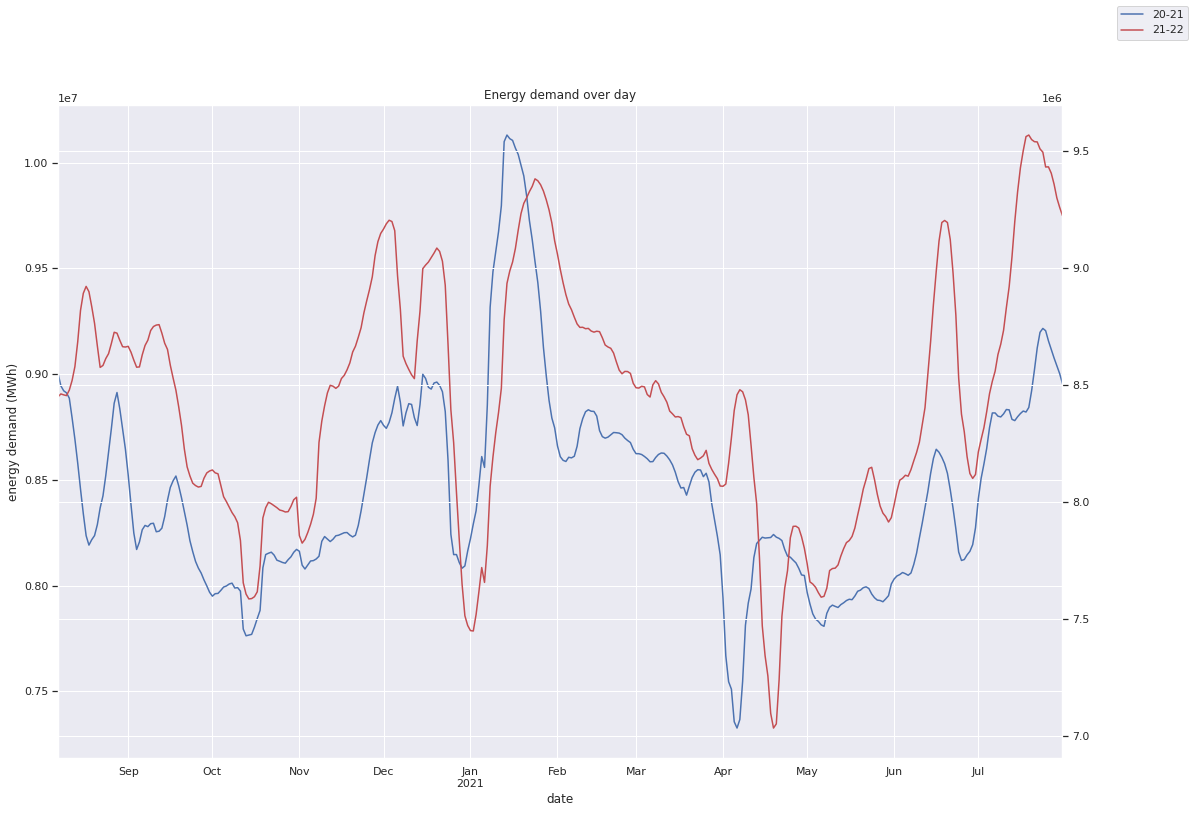

In [ ]:
sns.set(rc = {'figure.figsize':(18,12)})
ax = query_years.plot(x="date", y="20-21", legend=False)
ax2 = ax.twinx()
ax.set(xlabel='date', ylabel='energy demand (MWh)')
query_years.plot(x="date", y="21-22", ax=ax2, legend=False, color="r").set(title='Energy demand over day')
ax.figure.legend()
plt.show()

It is strange that, around April, the curve is slightly moved to the right. We'll extract the day of each one of those minimum crests to be able to do some conclusions.

In [ ]:
# Extract the date of the minimum crest of 20-21
blue_crest = query_years[query_years["20-21"] == query_years["20-21"].min()]
blue_crest
# April 4th: end of "Semana Santa" 2021

,date,20-21,21-22
242,2021-04-06,7.325993e+06,8.457451e+06


In [ ]:
# Extract the date of the minimum crest of 22-23
red_crest = query_years[query_years["21-22"] == query_years["21-22"].min()]
red_crest
# April 17th: end of "Semana Santa" 2022

,date,20-21,21-22
255,2021-04-19,8.241449e+06,7.033960e+06


The fact that those values were displaced in the x axis is due to the different dates of the two "Semana Santa" of the different years. The minimum crest, in both cases, is 2 days after the last day of "Semana Santa".

## Which month of the year has the highest consumption? Does the consumption trend change over the seasons?

[Text(0.5, 1.0, 'Energy demand over the months')]

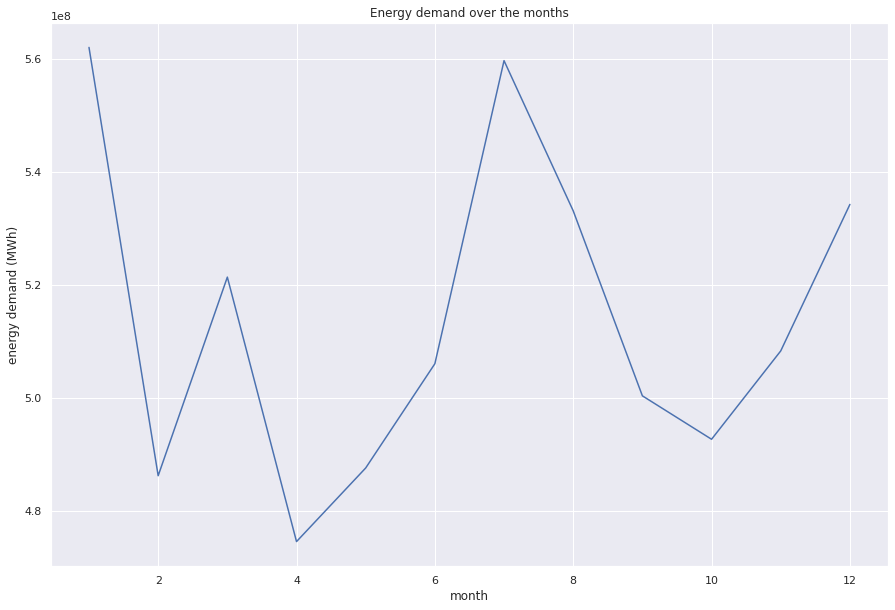

In [ ]:
# Groupby by month and make a lineplot to take a fast visualization of the data
gbmonth = query1.groupby(by = 'month').sum()
fig_dims = (15,10)
fig, ax = plt.subplots(figsize = fig_dims)
ax.set(xlabel='month', ylabel='energy demand (MWh)')
sns.lineplot(data = gbmonth, x = "month", y = "real").set(title='Energy demand over the months')

In [ ]:
# Remove unnecessary data and sort the values by the months with more energy demand
gbmonth = gbmonth.filter(['month','real'], axis = 1)
gbmonth = gbmonth.sort_values(by = 'real', ascending = False)
gbmonth = gbmonth.reset_index()
gbmonth.head()

,month,real
0,1,562036244
1,7,559693039
2,12,534243595
3,8,533107758
4,3,521377142


The months with more energy consumption were January, July, December and August, the ones with Holidays and more extreme temperature conditions.

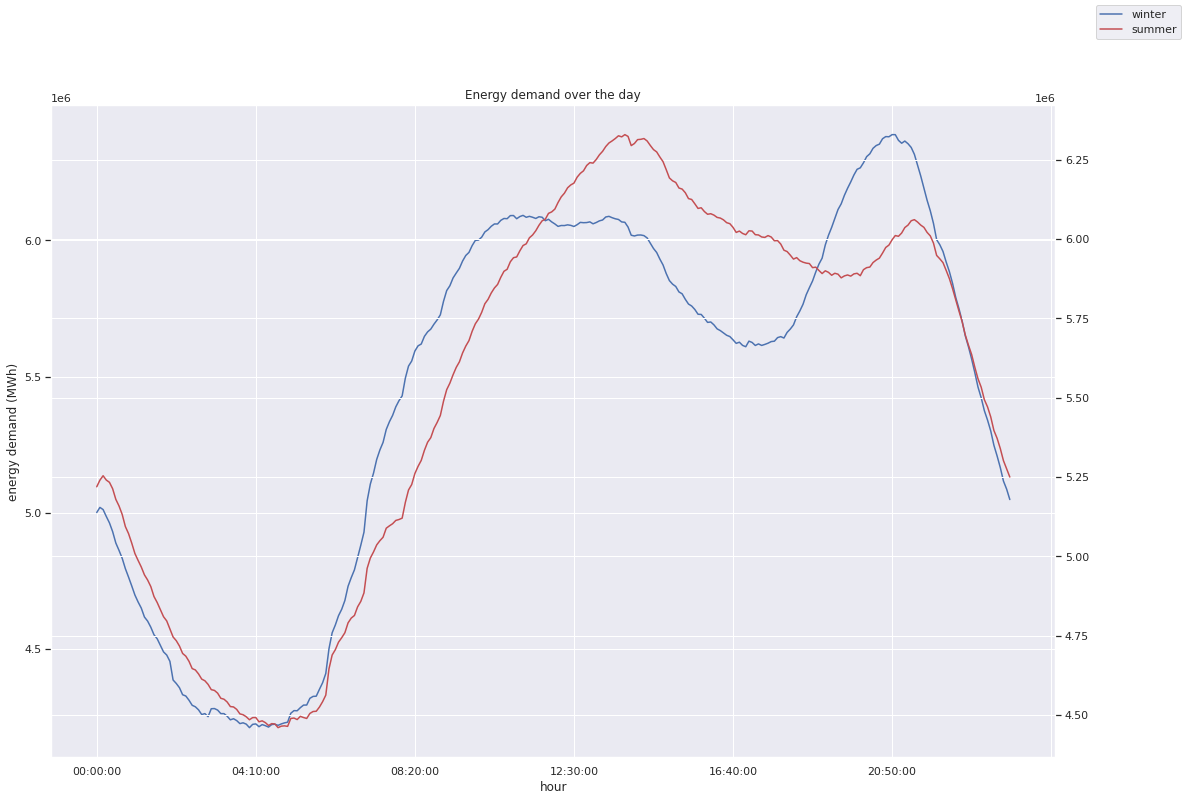

In [ ]:
# Create one dataset with winter data and another one with summer data
query1_winter = query1[query1['season'] == 'winter']

# In both of them, group by hour
gbhour_winter = query1_winter.groupby(by = 'hour').sum()
query1_summer = query1[query1['season'] == 'summer']
gbhour_summer = query1_summer.groupby(by = 'hour').sum()

# Create a dataset that contains the data of both seasons
summer_winter = gbhour_winter.filter(['hour','real'], axis = 1)
summer_winter = summer_winter.rename(columns = {'real':'winter'})
summer_winter = summer_winter.reset_index()
summer = list(gbhour_summer['real'])
summer_winter['summer'] = summer

sns.set(rc = {'figure.figsize':(18,12)})
ax = summer_winter.plot(x="hour", y="winter", legend=False)
ax2 = ax.twinx()
ax.set(xlabel='hour', ylabel='energy demand (MWh)')
summer_winter.plot(x="hour", y="summer", ax=ax2, legend=False, color="r").set(title='Energy demand over the day')
ax.figure.legend()
plt.show()

We see that, on winter, the energy consumption on the afternoon starts earlier. This is due to having less hours of light.

## Does a correlation exist between the real demand and the expected one? Check by month and hour. Compare for both years.

[Text(0.5, 1.0, 'Real and expected Energy demand correlation by months')]

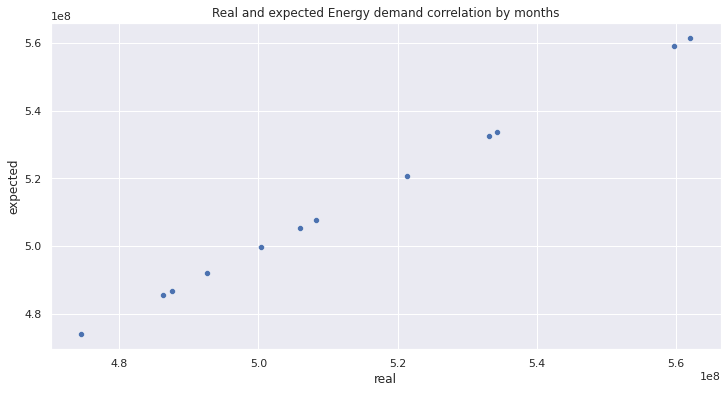

In [ ]:
# Group by month and make a scatterplot between real and expected to see its correlation
gbmonth = query1.groupby(by = 'month').sum()
gbmonth = gbmonth.reset_index()
fig_dims = (12,6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.scatterplot(data=gbmonth, x="real", y="expected").set(title='Real and expected Energy demand correlation by months')

[Text(0.5, 1.0, 'Real and expected Energy demand correlation by date and time')]

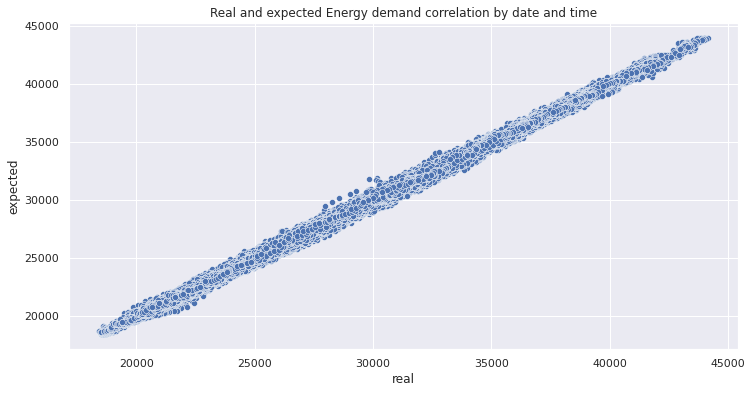

In [ ]:
# This scatterplot shows the correlation of both of them in the whole data
fig_dims = (12,6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.scatterplot(data=query1, x="real", y="expected").set(title='Real and expected Energy demand correlation by date and time')

[Text(0.5, 1.0, 'Real and expected Energy demand correlation by hour')]

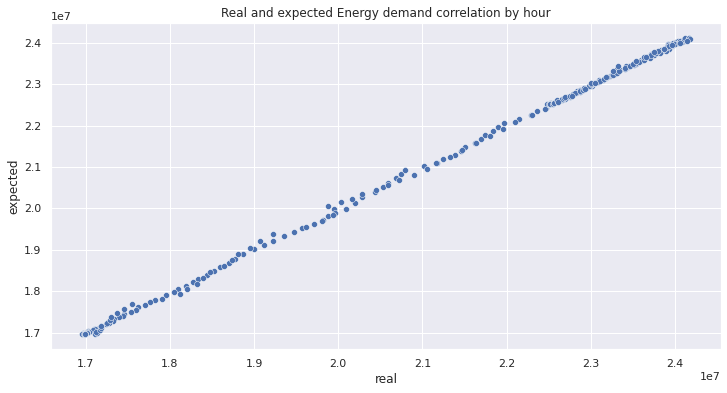

In [ ]:
# This scatterplot shows the correlation of the hours of the day
gbhour = query1.groupby(by = 'hour').sum()
fig_dims = (12,6)
fig, ax = plt.subplots(figsize = fig_dims)
sns.scatterplot(data = gbhour, x = 'real', y = 'expected').set(title='Real and expected Energy demand correlation by hour')

We see that, in all kinds of rearrangements, the real demand and the expected one show a high positive correlation between them.

## Which ones are the days with higher consumption than the average? Is there any relationship among them?

In [ ]:
# Group by the date
gbdate = query1.groupby(by = ['date','month']).sum()

# Filter for those days with a consumption higher than the average
gbdate = gbdate[gbdate['real'] > gbdate['real'].mean()]
gbdate.reset_index(inplace = True)

# Extract the day of the week of all those dates
gbdate['date'] = gbdate['date'].astype('datetime64[ns]')
gbdate['weekday'] = gbdate['date'].dt.day_name()
gbdate.head()

,date,month,real,expected,scheduled,weekday
0,2020-08-01,8,8886255,8862457,8872416,Saturday
1,2020-08-03,8,8978265,8981649,8974428,Monday
2,2020-08-04,8,9048086,9018401,9025632,Tuesday
3,2020-08-05,8,9256489,9227962,9221856,Wednesday
4,2020-08-06,8,9374653,9358507,9355548,Thursday


In [ ]:
# Try to see if those days have the same day of the week
gbweekday = gbdate.groupby(by = 'weekday').count()
gbweekday.reset_index(inplace = True)
total_count = gbweekday['real'].sum()

# Calculate the percentage of every day of the week for those dates
gbweekday['percentage'] = gbweekday['date']*100/total_count
gbweekday.sort_values(by = 'percentage', ascending = False, inplace = True)
gbweekday

,weekday,date,month,real,expected,scheduled,percentage
6,Wednesday,82,82,82,82,82,21.134021
4,Thursday,81,81,81,81,81,20.876289
5,Tuesday,75,75,75,75,75,19.329897
0,Friday,74,74,74,74,74,19.072165
1,Monday,55,55,55,55,55,14.175258
2,Saturday,19,19,19,19,19,4.896907
3,Sunday,2,2,2,2,2,0.515464


Around a 5% of the days higher than the mean were on weekend. As we saw on previous questions, on weekends the energy consumption is lower.

In [ ]:
gbdate.head()

,date,month,real,expected,scheduled,weekday
0,2020-08-01,8,8886255,8862457,8872416,Saturday
1,2020-08-03,8,8978265,8981649,8974428,Monday
2,2020-08-04,8,9048086,9018401,9025632,Tuesday
3,2020-08-05,8,9256489,9227962,9221856,Wednesday
4,2020-08-06,8,9374653,9358507,9355548,Thursday


In [ ]:
# This query doesn't have the season. Create a column with the season using the same criteria
conditions = [(gbdate['month'] <= 3), (gbdate['month'] > 3) & (gbdate['month'] <= 6), (gbdate['month'] > 6) & (gbdate['month'] <= 9), (gbdate['month'] > 9)]
values = ['winter','spring','summer','autumn']
gbdate['season'] = np.select(conditions, values)
gbdate.head()


,date,month,real,expected,scheduled,weekday,season
0,2020-08-01,8,8886255,8862457,8872416,Saturday,summer
1,2020-08-03,8,8978265,8981649,8974428,Monday,summer
2,2020-08-04,8,9048086,9018401,9025632,Tuesday,summer
3,2020-08-05,8,9256489,9227962,9221856,Wednesday,summer
4,2020-08-06,8,9374653,9358507,9355548,Thursday,summer


In [ ]:
# Group by the season
gbseason = gbdate.groupby(by = 'season').count()
gbseason.reset_index(inplace = True)
total_count = gbseason['real'].sum()

# Calculate the percentage of each season
gbseason['percentage'] = gbseason['date']*100/total_count
gbseason.sort_values(by = 'percentage', ascending = False, inplace = True)
gbseason

,season,date,month,real,expected,scheduled,weekday,percentage
3,winter,127,127,127,127,127,127,32.731959
2,summer,121,121,121,121,121,121,31.185567
0,autumn,86,86,86,86,86,86,22.164948
1,spring,54,54,54,54,54,54,13.917526


We see that most of the days are on winter or summer, just like we saw on previous analysis.

## Query 2

In [ ]:
query_job = """
WITH
  genem AS (
  SELECT
    gen.date,
    SUM(gen.generation) AS generation,
    SUM(em.emission) AS emission
  FROM
    `energy-ree-project.energy_generic_info.energy-generation-ree` AS gen
  LEFT JOIN
    `energy-ree-project.energy_generic_info.co2-emission-ree` AS em
  ON
    gen.date = em.date
    AND gen.hour = em.hour
    AND gen.energy_source_id = em.energy_source_id
  GROUP BY
    gen.date )
SELECT
  genem.date,
  genem.generation,
  genem.emission,
  dem.demand,
  CASE
    WHEN EXTRACT(month FROM genem.date) < 4 THEN 'winter'
    WHEN EXTRACT(month FROM genem.date) < 7 THEN 'spring'
    WHEN EXTRACT(month FROM genem.date) < 10 THEN 'summer'
  ELSE
  'autumn'
END
  AS season
FROM
  genem
LEFT JOIN (
  SELECT
    date,
    SUM(real) AS demand
  FROM
    `energy-ree-project.energy_generic_info.energy-demand-ree`
  GROUP BY
    date ) AS dem
ON
  genem.date = dem.date;
"""

query2 = pd.read_gbq(query_job, project_id=project_id, credentials = credentials, dialect='standard')

In [ ]:
query2.head()

,date,generation,emission,demand,season
0,2020-08-01,8798720.0,1356142.10,8886255,summer
1,2020-08-02,8537141.0,1151543.40,8114228,summer
2,2020-08-03,9093209.0,1359706.60,8978265,summer
3,2020-08-04,9126606.0,1486672.30,9048086,summer
4,2020-08-05,8903729.0,1558216.72,9256489,summer


This query shows the demand, generation and emission with granularity by day and season. In order to have the same structure, generation and emission don't show the values for the different energy sources.

I will answer the following questions regarding the energy demand in Spain:

*  Does a correlation exist among generation, emission and demand?
*  Which season has the highest demand, generation and emission? And the month?


The next questions will be answered with the resulting table of the second query. Therefore, I'll do a little previous analysis of this query.

In [ ]:
# Check how many columns and attributes the data set has
query2.shape

(730, 5)

In [ ]:
# Checking the name of the columns
query2.columns

Index(['date', 'generation', 'emission', 'demand', 'season'], dtype='object')

In [ ]:
# Extracting the basic statistics of the data set
query2.describe()

,generation,emission,demand
count,7.300000e+02,7.300000e+02,7.300000e+02
mean,8.560171e+06,1.198363e+06,8.446898e+06
std,8.789920e+05,3.884455e+05,7.730649e+05
min,6.142861e+06,4.590691e+05,6.300834e+06
25%,7.938683e+06,8.969343e+05,8.023412e+06
50%,8.538422e+06,1.155345e+06,8.505662e+06
75%,9.114200e+06,1.414856e+06,8.959404e+06
max,1.105538e+07,2.529233e+06,1.063589e+07


In [ ]:
# Since the data was previously cleaned, there are no missing values
query2.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        730 non-null    dbdate 
 1   generation  730 non-null    float64
 2   emission    730 non-null    float64
 3   demand      730 non-null    Int64  
 4   season      730 non-null    object 
dtypes: Int64(1), dbdate(1), float64(2), object(1)
memory usage: 29.4+ KB


In [ ]:
# Switch the date column into datetime
query2['date'] = query2['date'].astype('datetime64[ns]')

## Does a correlation exist among generation, emission and demand?

[Text(0.5, 1.0, 'Demand, generation and emission correlation')]

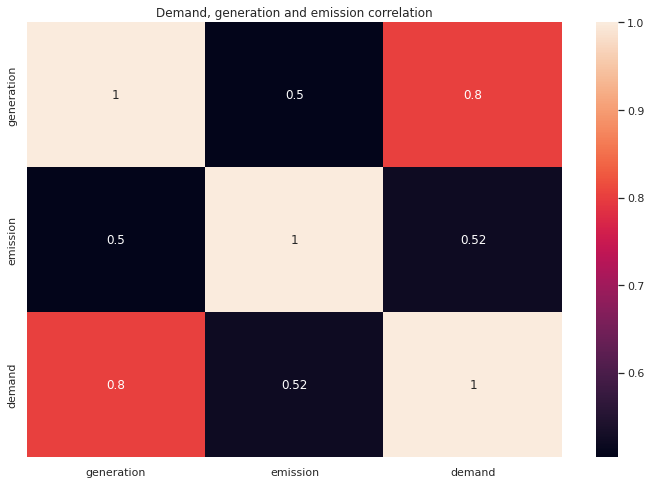

In [ ]:
# Check the correlation among these three columns, create a heatmap
fig_dims = (12,8)
fig, ax = plt.subplots(figsize = fig_dims)
sns.heatmap(query2.corr(), annot=True).set(title='Demand, generation and emission correlation')

We see that demand and generation have some correlation, but emission has a low correlation with generation and with demand.

## Which season has the highest demand, generation and emission?

In [ ]:
# Group the data by season
gbseason = query2.groupby(by = 'season').sum()
gbseason = gbseason.filter(['season','demand','generation','emission'])
gbseason.sort_values(by = 'demand', ascending = False, inplace = True)
gbseason.reset_index(inplace = True)
total_dem = gbseason['demand'].sum()
total_gen = gbseason['generation'].sum()
total_em = gbseason['emission'].sum()

# Calculate the percentage of all of them
gbseason['demand %'] = gbseason['demand']*100/total_dem
gbseason['generation %'] = gbseason['generation']*100/total_gen
gbseason['emission %'] = gbseason['emission']*100/total_em

# Drop the initial columns
gbseason.drop(['demand','generation','emission'], axis = 1, inplace = True)
gbseason

,season,demand %,generation %,emission %
0,summer,25.836897,25.715667,28.200492
1,winter,25.455313,25.457109,22.851221
2,autumn,24.897411,24.874670,25.512214
3,spring,23.81038,23.952554,23.436074


[Text(0.5, 1.0, 'Energy demand, generation and emission percentages over the seasons')]

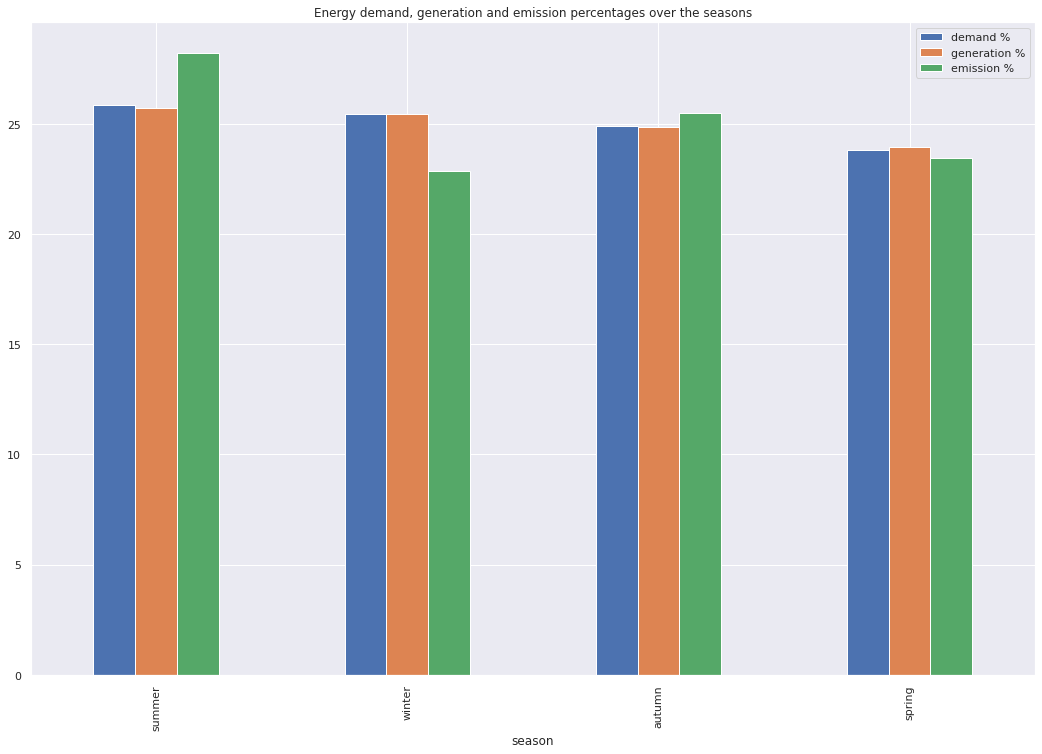

In [ ]:
sns.set(rc = {'figure.figsize':(18,12)})
ax.set(xlabel='season', ylabel='energy percentage')
gbseason.plot(x="season", y=["demand %", "generation %", "emission %"], kind="bar").set(title='Energy demand, generation and emission percentages over the seasons')

If we measure them by seasons, emissions has a slight difference over the seasons, but generation and demand don't.

## Query 3

In [ ]:
query_job = """
   SELECT
  CAST(gen.date AS string) AS date,
  CAST(gen.hour AS string) AS hour,
  gen.energy_source_id,
  gen.generation,
  em.emission,
  EXTRACT(month FROM gen.date) AS month,
  CASE
    WHEN EXTRACT(month FROM gen.date) < 4 THEN 'winter'
    WHEN EXTRACT(month FROM gen.date) < 7 THEN 'spring'
    WHEN EXTRACT(month FROM gen.date) < 10 THEN 'summer'
  ELSE
  'autumn'
END
  AS season,
  CASE
    WHEN gen.date < '2021-08-01' THEN '20-21'
  ELSE
  '21-22'
END
  AS year
FROM
  `energy-ree-project.energy_generic_info.energy-generation-ree` AS gen
LEFT JOIN
  `energy-ree-project.energy_generic_info.co2-emission-ree` AS em
ON
  gen.date = em.date
  AND gen.hour = em.hour
  AND gen.energy_source_id = em.energy_source_id
ORDER BY
  gen.date,
  gen.hour,
  gen.energy_source_id;"""

query3 = pd.read_gbq(query_job, project_id=project_id, credentials = credentials, dialect='standard')

In [ ]:
query3.head()

,date,hour,energy_source_id,generation,emission,month,season,year
0,2020-08-01,00:00:00,0,2876.0,0.0,8,summer,20-21
1,2020-08-01,00:00:00,1,6959.0,0.0,8,summer,20-21
2,2020-08-01,00:00:00,2,437.0,415.0,8,summer,20-21
3,2020-08-01,00:00:00,3,11104.0,4204.0,8,summer,20-21
4,2020-08-01,00:00:00,4,4285.0,0.0,8,summer,20-21


This query shows the generation and emission with granularity by hour, day, month, season and year. It also contains the different energy source id's.

I will answer the following questions regarding the generation and emission of the different energy sources:

*  How is the evolution of the generation and emission through time? And through the day? And in 20-21 and 21-22?
*  Which ones are the days with a generation or emission higher than the average? Exists any relationship among them? For instance, all of them are weekend or from the same season. Are these days the same for generation and emission?


The next questions will be answered with the resulting table of the third query. Therefore, I'll do a little previous analysis of this query.

In [ ]:
# Check how many columns and attributes the data set has
query3.shape

(2732808, 8)

In [ ]:
# Checking the name of the columns
query3.columns

Index(['date', 'hour', 'energy_source_id', 'generation', 'emission', 'month',
       'season', 'year'],
      dtype='object')

In [ ]:
# Extracting the basic statistics of the data set
query3.describe()

,energy_source_id,generation,emission,month
count,2.732808e+06,2.732808e+06,2.732808e+06,2.732808e+06
mean,6.000000e+00,2.286631e+03,3.201121e+02,6.526430e+00
std,3.741658e+00,3.063783e+03,7.202525e+02,3.447843e+00
min,0.000000e+00,-3.096000e+03,0.000000e+00,1.000000e+00
25%,3.000000e+00,1.180000e+02,0.000000e+00,4.000000e+00
50%,6.000000e+00,5.820000e+02,0.000000e+00,7.000000e+00
75%,9.000000e+00,3.636000e+03,2.180000e+02,1.000000e+01
max,1.200000e+01,2.045200e+04,7.177000e+03,1.200000e+01


In [ ]:
# Since the data was previously cleaned, there are no missing values
query3.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2732808 entries, 0 to 2732807
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   hour              object 
 2   energy_source_id  Int64  
 3   generation        float64
 4   emission          float64
 5   month             Int64  
 6   season            object 
 7   year              object 
dtypes: Int64(2), float64(2), object(4)
memory usage: 172.0+ MB


In [ ]:
# Switch the date column into datetime
query3['date'] = query3['date'].astype('datetime64[ns]')

## How is the evolution of the generation and emission through time? And through the day? And in 20-21 and 21-22?

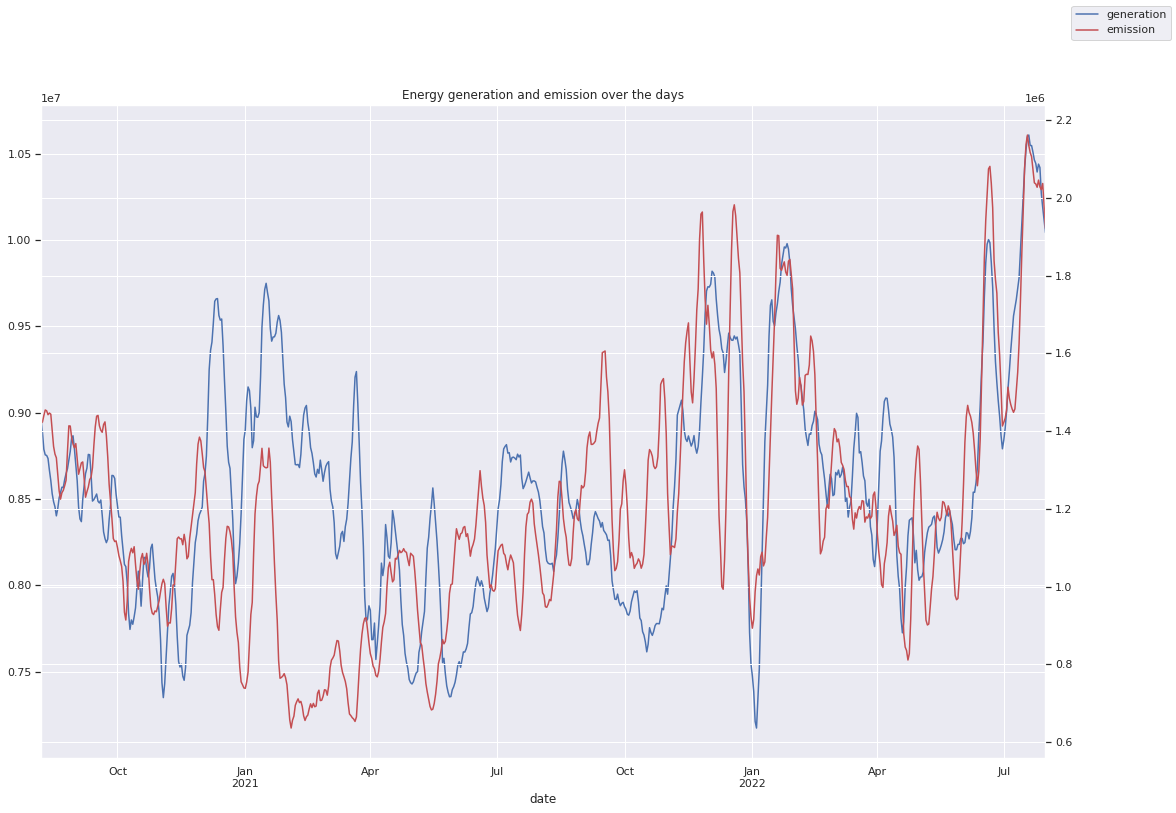

In [ ]:
# Group by date because of the different energy sources
gbdate = query3.groupby(by = 'date').sum() 

# Make a rolling average to avoid the distortion created by the weekends
rolling = gbdate.rolling(7).mean() 
rolling = rolling[rolling['generation'].notnull()]
rolling.reset_index(inplace = True)

ax = rolling.plot(x="date", y="generation", legend=False)
ax2 = ax.twinx()
sns.set(rc = {'figure.figsize':(18,12)})
rolling.plot(x="date", y="emission", ax=ax2, legend=False, color="r").set(title='Energy generation and emission over the days')
ax.figure.legend()
plt.show()

In this case you can see a trend, but the correlation between these two magnitudes is not very high, as we've previously seen.

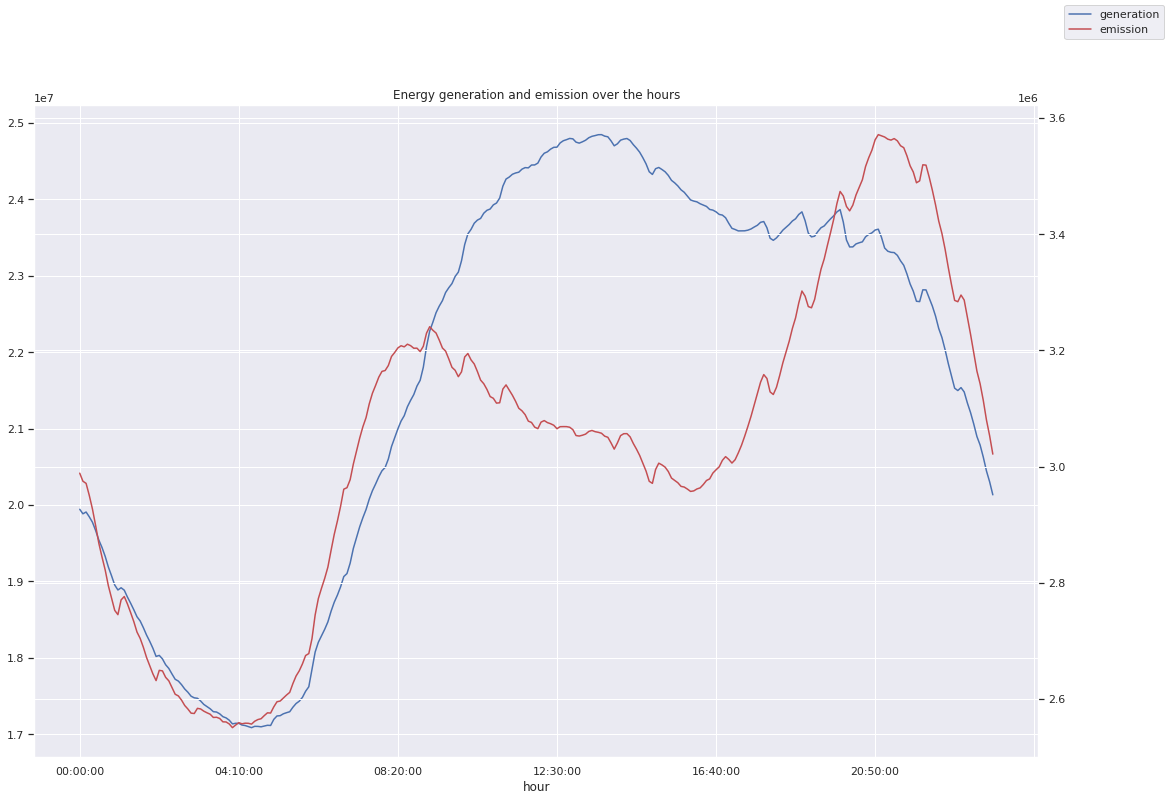

In [ ]:
# Group by hour and do a lineplot with generation and emission
gbhour = query3.groupby(by = 'hour').sum() 
gbhour.reset_index(inplace = True)

ax = gbhour.plot(x="hour", y="generation", legend=False)
ax2 = ax.twinx()
sns.set(rc = {'figure.figsize':(18,12)})
gbhour.plot(x="hour", y="emission", ax=ax2, legend=False, color="r").set(title='Energy generation and emission over the hours')
ax.figure.legend()
plt.show()

We see that at 4 AM generation and emission start increasing, due to people waking up. We see the same trend in demand. The curious thing is that generation and demand keep increasing, but emission increases until 8:20. One of the main factors is that then we have daylight and solar energy. To reinforce the hypothesis of the renewable energies contribution, it should be very interesting to see the trend of renewable energy source generation during the day. We will cover this later on the analysis.

In [ ]:
gbhour = gbhour[gbhour['emission'] == gbhour['emission'].max()]
gbhour

,hour,energy_source_id,generation,emission,month
251,20:55:00,56940,23609131.0,3571479.82,61932


We see that the maximum emission is at 20:55

## Which ones are the days with a generation or emission higher than the average? Exists any relationship among them? For instance, all of them are weekend or from the same season. Are these days the same for generation and emission?

In [ ]:
# Filter for the days that have a generation or emission higher than the average
gendate = gbdate[gbdate['generation'] > gbdate['generation'].mean()]
emdate = gbdate[gbdate['emission'] > gbdate['emission'].mean()]
gendate = gendate.reset_index()
emdate = emdate.reset_index()

# Count how many days of one dataset are in the other one
gendates = list(gendate['date'])
emdates = list(emdate['date'])
counter = 0
for i in gendates:
  if i in emdates:
    counter += 1
    
# Calculate the percentage of those days
print(counter*100/len(gendates))

57.5


In [ ]:
# Convert the date column into datetime
gendate['date'] = pd.to_datetime(gendate['date'], format = '%Y-%m-%d')
emdate['date'] = pd.to_datetime(emdate['date'], format = '%Y-%m-%d')

# Extract the day of the week of those days
gendate['weekday'] = gendate['date'].dt.day_name()
emdate['weekday'] = emdate['date'].dt.day_name()

# Group by the day of the week
gendate = gendate.groupby(by = 'weekday').count()
emdate = emdate.groupby(by = 'weekday').count()

# Create the percentage of each day of the week
gendate['percentage'] = gendate['date']*100/gendate['date'].sum()
emdate['percentage'] = emdate['date']*100/emdate['date'].sum() 
gendate.sort_values('percentage', ascending = False, inplace = True)
emdate.sort_values('percentage', ascending = False, inplace = True)
gendate

,date,energy_source_id,generation,emission,month,percentage
weekday,,,,,,
Tuesday,68,68,68,68,68,18.888889
Wednesday,67,67,67,67,67,18.611111
Thursday,66,66,66,66,66,18.333333
Friday,63,63,63,63,63,17.500000
Monday,58,58,58,58,58,16.111111
Saturday,24,24,24,24,24,6.666667
Sunday,14,14,14,14,14,3.888889


We see that 57.5% of the dates that generation is higher than the average, so is emission. That's not a very high value. All of the days were "entre semana" in a pretty regular distribution.

## Query 4

In [ ]:
query_job = """
SELECT
  CAST(gen.date AS string) AS date,
  CAST(gen.hour AS string) AS hour,
  gen.generation,
  em.emission,
  tm.energy_source_name_en,
  tm.energy_source_class_1
FROM
  `energy-ree-project.energy_generic_info.energy-generation-ree` AS gen
LEFT JOIN
  `energy-ree-project.energy_generic_info.co2-emission-ree` AS em
ON
  gen.date = em.date
  AND gen.hour = em.hour
  AND gen.energy_source_id = em.energy_source_id
LEFT JOIN
  `energy-ree-project.energy_generic_info.dim-basic-energy-data` AS tm
ON
  gen.energy_source_id = tm.energy_source_id;"""

query4 = pd.read_gbq(query_job, project_id=project_id, credentials = credentials, dialect='standard')

In [ ]:
query4.head()

,date,hour,generation,emission,energy_source_name_en,energy_source_class_1
0,2020-08-01,00:00:00,2876.0,0.0,wind,renewable energy
1,2020-08-01,00:05:00,2924.0,0.0,wind,renewable energy
2,2020-08-01,00:10:00,3042.0,0.0,wind,renewable energy
3,2020-08-01,00:15:00,3082.0,0.0,wind,renewable energy
4,2020-08-01,00:20:00,3124.0,0.0,wind,renewable energy


This query shows the generation and emission for all hours and days and for all energy sources. It also contains the energy source class (if it's renewable or not).

I will answer the following questions regarding the generation and emission of the different energy sources:
*  For each source of energy, plot the generation over time. What trends can you see? Do they change depending on the month?
*  Repeat the previous exercise with emission.


The next questions will be answered with the resulting table of the fourth query. Therefore, I'll do a little previous analysis of this query.

In [ ]:
# Check how many columns and attributes the data set has
query4.shape

(2732808, 6)

In [ ]:
# Checking the name of the columns
query4.columns

Index(['date', 'hour', 'generation', 'emission', 'energy_source_name_en',
       'energy_source_class_1'],
      dtype='object')

In [ ]:
# Extracting the basic statistics of the data set
query4.describe()

,generation,emission
count,2.732808e+06,2.732808e+06
mean,2.286631e+03,3.201121e+02
std,3.063783e+03,7.202525e+02
min,-3.096000e+03,0.000000e+00
25%,1.180000e+02,0.000000e+00
50%,5.820000e+02,0.000000e+00
75%,3.636000e+03,2.180000e+02
max,2.045200e+04,7.177000e+03


In [ ]:
# Since the data was previously cleaned, there are no missing values
query4.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2732808 entries, 0 to 2732807
Data columns (total 6 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date                   object 
 1   hour                   object 
 2   generation             float64
 3   emission               float64
 4   energy_source_name_en  object 
 5   energy_source_class_1  object 
dtypes: float64(2), object(4)
memory usage: 125.1+ MB


In [ ]:
# Switch the date column into datetime
query4['date'] = query4['date'].astype('datetime64[ns]')
# query4['hour'] = pd.to_timedelta(query4['hour'])
query4.head()

,date,hour,generation,emission,energy_source_name_en,energy_source_class_1
0,2020-08-01,00:00:00,2876.0,0.0,wind,renewable energy
1,2020-08-01,00:05:00,2924.0,0.0,wind,renewable energy
2,2020-08-01,00:10:00,3042.0,0.0,wind,renewable energy
3,2020-08-01,00:15:00,3082.0,0.0,wind,renewable energy
4,2020-08-01,00:20:00,3124.0,0.0,wind,renewable energy


## How is the evolution of the renewable energies generation during the day?

In [ ]:
# Create a dataframe only with wind energy and group it by hour
dfrenew = query4[query4['energy_source_class_1'] == 'renewable energy']
dfrenew = dfrenew.groupby(['hour','energy_source_name_en']).sum()
dfrenew = dfrenew.drop('emission', axis = 1)
dfrenew = dfrenew.reset_index()

#Convert from long format to wide format
dfrenew = pd.pivot(dfrenew, index = 'hour', columns = 'energy_source_name_en', values = 'generation')
dfrenew.reset_index(inplace = True)
dfrenew.head()

energy_source_name_en,hour,hydropower,nuclear,photovoltaic solar,renewable thermal,thermal solar,wind
0,00:00:00,1966104.0,4649558.0,15317.0,407876.0,164186.0,5452442.0
1,00:05:00,1956113.0,4647543.0,15160.0,408622.0,162974.0,5444982.0
2,00:10:00,1985633.0,4647562.0,14900.0,408622.0,161770.0,5441947.0
3,00:15:00,1975465.0,4648417.0,14647.0,408550.0,160628.0,5437631.0
4,00:20:00,1967787.0,4647613.0,14444.0,408622.0,159431.0,5430754.0


In [ ]:
dfrenew.dtypes

energy_source_name_en
hour                   object
hydropower            float64
nuclear               float64
photovoltaic solar    float64
renewable thermal     float64
thermal solar         float64
wind                  float64
dtype: object

[Text(0.5, 1.0, 'Energy sources generation over the hours (renewable)')]

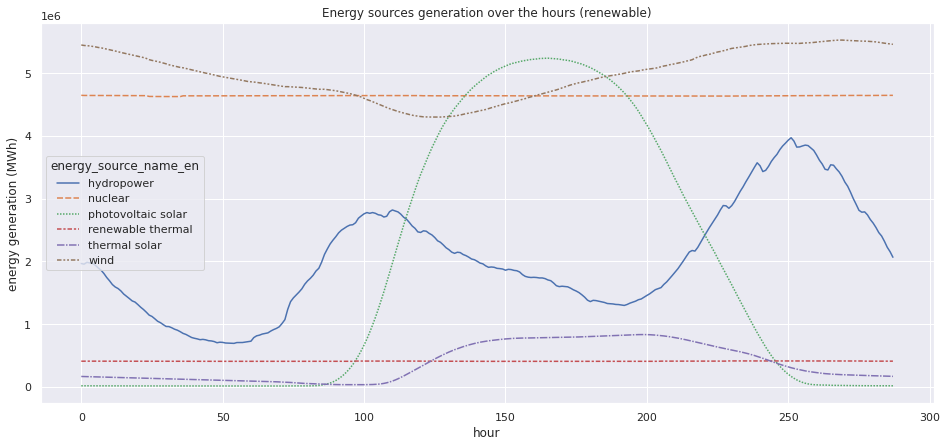

In [ ]:
# Plot the previous dataframe
fig_dims = (16,7)
fig, ax = plt.subplots(figsize = fig_dims)
ax.set(xlabel='hour', ylabel='energy generation (MWh)')
sns.set(rc = {'figure.figsize':(12,8)})
sns.lineplot(data = dfrenew).set(title='Energy sources generation over the hours (renewable)')

In this graph we can see some trends that help with the explanation of the emission over the generation from 8 AM to lunchtime.
*  Photovoltaic solar energy shows energy generation during the day, as expected. So does Thermal solar, but with lower quantity.
*  Hydropower shows two peaks: in the morning and in the evening.
*  Wind energy shows a minimum in the morning. Other than that, its generation is pretty stable.
*  Since nuclear energy does not depend on the weather or the hour, it has a very stable value over the hours.

With this in mind, the emission levels decreasing from the morning to dinnertime are due to a contribution by hydropower energy, photovoltaic solar and wind energy. That's why, despite generation being so high during the day, emission is not that high. An important percentage of that energy is generated through renewable energy sources.

## For each source of energy, plot the generation over time. What trends can you see? Do they change depending on the month?

In [ ]:
# Filter by renewable energy sources
renew = query4[query4['energy_source_class_1'] == 'renewable energy']
renew = renew.filter(['date','hour','generation','energy_source_name_en'])

# Convert from long format into wide format
renew = pd.pivot(renew, index = ['date','hour'], columns = 'energy_source_name_en', values = 'generation')
renew.reset_index(inplace = True)
renew = renew.groupby('date').sum()
renew.reset_index(inplace = True)
renew.head()

energy_source_name_en,date,hydropower,nuclear,photovoltaic solar,renewable thermal,thermal solar,wind
0,2020-08-01,720481.0,1997738.0,669970.0,142810.0,255980.0,1568039.0
1,2020-08-02,238129.0,2002963.0,741527.0,130253.0,300796.0,2204108.0
2,2020-08-03,703791.0,2007341.0,726046.0,136480.0,275230.0,1820532.0
3,2020-08-04,701413.0,2008571.0,758306.0,139218.0,293396.0,1518641.0
4,2020-08-05,952459.0,2007857.0,795743.0,137993.0,321382.0,799306.0


In [ ]:
# To improve the data visualization I do a rolling average
num_columns = list(renew.columns[1:])
renew = renew.set_index('date')
renew = renew.rolling(7).mean()
renew = renew[renew['hydropower'].notnull()]
renew = renew.reset_index()
for i in num_columns:
  renew[i] = renew[i]/renew[i][0]
renew.head()

energy_source_name_en,date,hydropower,nuclear,photovoltaic solar,renewable thermal,thermal solar,wind
0,2020-08-07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2020-08-08,0.973447,1.000513,0.999733,1.005518,0.966854,0.961860
2,2020-08-09,1.023627,1.000503,0.996504,1.028228,0.933679,0.848817
3,2020-08-10,1.044915,1.000275,0.970814,1.050629,0.874947,0.811667
4,2020-08-11,1.053799,0.999917,0.921248,1.067709,0.788853,0.839584


In [ ]:
renew = renew.set_index('date')
renew.head()

energy_source_name_en,hydropower,nuclear,photovoltaic solar,renewable thermal,thermal solar,wind
date,,,,,,
2020-08-07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-08-08,0.973447,1.000513,0.999733,1.005518,0.966854,0.961860
2020-08-09,1.023627,1.000503,0.996504,1.028228,0.933679,0.848817
2020-08-10,1.044915,1.000275,0.970814,1.050629,0.874947,0.811667
2020-08-11,1.053799,0.999917,0.921248,1.067709,0.788853,0.839584


[Text(0.5, 1.0, 'Energy sources generation over the days (renewable)')]

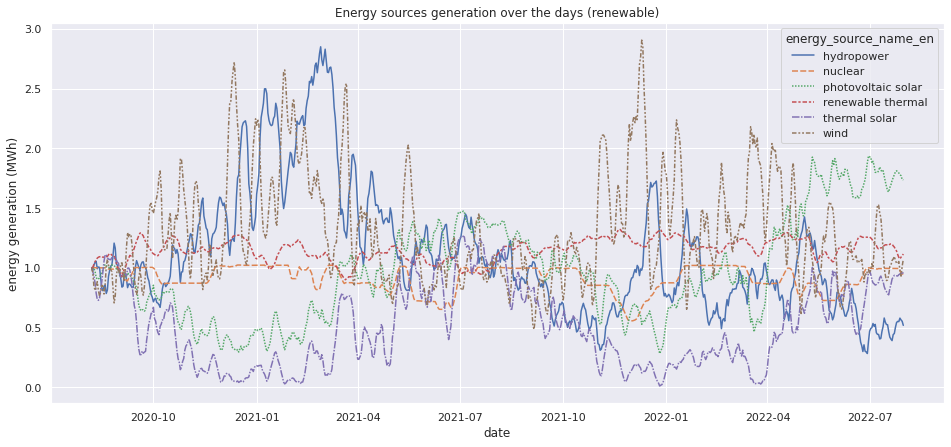

In [ ]:
fig_dims = (16,7)
fig, ax = plt.subplots(figsize = fig_dims)
ax.set(xlabel='date', ylabel='energy generation (MWh)')
sns.set(rc = {'figure.figsize':(12,8)})
sns.lineplot(data = renew).set(title='Energy sources generation over the days (renewable)')

We see that, on summer, all the energy sources have a similar generation value, but on the rest of the seasons there are some sources that have a lower energy generation (like thermal solar and photovoltaic solar), other ones that have higher values on those seasons (like hydropower and wind) and energy sources that keep the same values (like nuclear and renewable thermal).
It makes sense that the energy sources that come from the Sun have higher values in summer than the rest of the seasons.
It also makes sense that hydropower and wind generate less energy on summer.

In [ ]:
# Filter by non renewable energy sources
nonrenew = query4[query4['energy_source_class_1'] == 'non renewable energy']
nonrenew = nonrenew.filter(['date','hour','generation','energy_source_name_en'])
nonrenew = pd.pivot(nonrenew, index = ['date','hour'], columns = 'energy_source_name_en', values = 'generation')
nonrenew.reset_index(inplace = True)
nonrenew = nonrenew.groupby('date').sum()
nonrenew.reset_index(inplace = True)
nonrenew.drop('auxiliar generation', axis = 1, inplace = True)
nonrenew.head()

energy_source_name_en,date,charcoal,cogeneration and residues,combined cycle,diesel,gas turbine,steam turbine
0,2020-08-01,126048.0,951282.0,2207582.0,92717.0,22546.0,43527.0
1,2020-08-02,126017.0,926926.0,1728356.0,77421.0,16180.0,44465.0
2,2020-08-03,169871.0,969756.0,2139357.0,81272.0,16165.0,47368.0
3,2020-08-04,197260.0,974573.0,2391506.0,72227.0,23974.0,47521.0
4,2020-08-05,171476.0,989559.0,2546652.0,76850.0,31462.0,72581.0


In [ ]:
# Improve the data visualization by performing rolling averages
num_columns = list(nonrenew.columns[1:])
nonrenew = nonrenew.set_index('date')
nonrenew = nonrenew.rolling(7).mean()
nonrenew = nonrenew[nonrenew['charcoal'].notnull()]
nonrenew = nonrenew.reset_index()
for i in num_columns:
  nonrenew[i] = nonrenew[i]/nonrenew[i][0]
nonrenew.head()

energy_source_name_en,date,charcoal,cogeneration and residues,combined cycle,diesel,gas turbine,steam turbine
0,2020-08-07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2020-08-08,1.004006,0.995964,1.005248,0.973347,1.017737,1.021914
2,2020-08-09,1.004356,0.993279,1.024719,0.965621,1.034237,1.045648
3,2020-08-10,0.975753,0.990066,1.045752,0.970435,1.080535,1.043561
4,2020-08-11,0.913123,0.987964,1.054604,0.990259,1.102818,1.030538


[Text(0.5, 1.0, 'Energy sources generation over the days (non renewable)')]

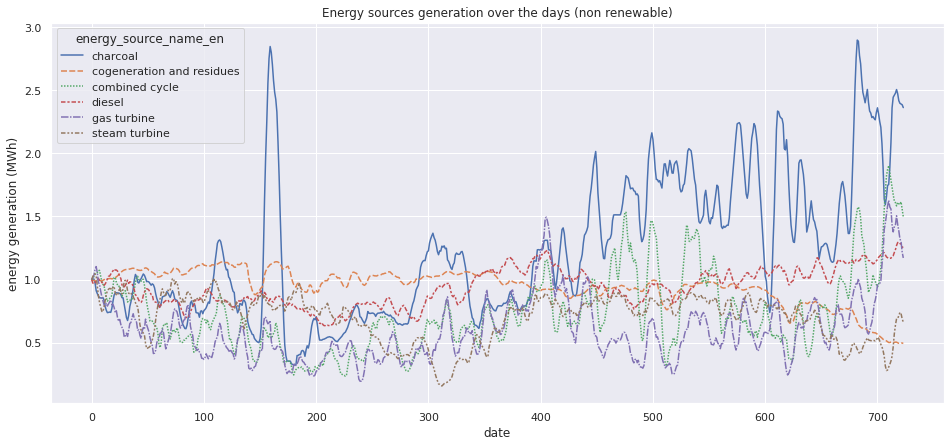

In [ ]:
fig_dims = (16,7)
fig, ax = plt.subplots(figsize = fig_dims)
ax.set(xlabel='date', ylabel='energy generation (MWh)')
sns.set(rc = {'figure.figsize':(12,8)})
sns.lineplot(data = nonrenew).set(title='Energy sources generation over the days (non renewable)')

There is an enormous peak on charcoal. It would be a good thing to know when did that happen. The other energy sources don't have a strong variation over the days. 

In [ ]:
cpeaks = nonrenew[nonrenew['charcoal'] > 2.8]
cpeaks

energy_source_name_en,date,charcoal,cogeneration and residues,combined cycle,diesel,gas turbine,steam turbine
159,2021-01-13,2.846407,1.118905,0.577671,0.848991,0.675356,0.799360
682,2022-06-20,2.897360,0.666579,1.556831,1.151502,0.966596,0.447218
683,2022-06-21,2.887931,0.640974,1.575274,1.147225,1.007060,0.435878


That peak on charcoal happened on January 13th 2021.

## Repeat the previous exercise with emission.

In [ ]:
# Filter by non renewable energy sources
nonrenew = query4[query4['energy_source_class_1'] == 'non renewable energy']
nonrenew = nonrenew.filter(['date','hour','emission','energy_source_name_en'])

# Convert the long format into a wide format
nonrenew = pd.pivot(nonrenew, index = ['date','hour'], columns = 'energy_source_name_en', values = 'emission')
nonrenew.reset_index(inplace = True)
nonrenew = nonrenew.groupby('date').sum()
nonrenew.reset_index(inplace = True)
nonrenew.drop('auxiliar generation', axis = 1, inplace = True)
nonrenew.head()

energy_source_name_en,date,charcoal,cogeneration and residues,combined cycle,diesel,gas turbine,steam turbine
0,2020-08-01,119712.0,266103.0,845675.0,63031.0,22432.1,39189.0
1,2020-08-02,119681.0,259280.0,663966.0,52645.0,15946.4,40025.0
2,2020-08-03,161344.0,271262.0,812777.0,55273.0,16410.6,42640.0
3,2020-08-04,187397.0,272557.0,909517.0,49116.0,25302.3,42783.0
4,2020-08-05,162908.0,276738.0,967286.0,52253.0,33383.0,65370.0


In [ ]:
# For a better data visualization I did a rolling average
num_columns = list(nonrenew.columns[1:])
nonrenew = nonrenew.set_index('date')
nonrenew = nonrenew.rolling(7).mean()
nonrenew = nonrenew[nonrenew['charcoal'].notnull()]
nonrenew = nonrenew.reset_index()

for i in num_columns:
  nonrenew[i] = nonrenew[i]/nonrenew[i][0]
nonrenew.head()

energy_source_name_en,date,charcoal,cogeneration and residues,combined cycle,diesel,gas turbine,steam turbine
0,2020-08-07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2020-08-08,1.004034,0.995965,1.003894,0.973410,1.019004,1.021891
2,2020-08-09,1.004373,0.993291,1.022242,0.965711,1.037492,1.045629
3,2020-08-10,0.975783,0.990081,1.043260,0.970506,1.075811,1.043521
4,2020-08-11,0.913152,0.987993,1.051735,0.990312,1.084854,1.030433


[Text(0.5, 1.0, 'Energy sources CO2 emission over the days')]

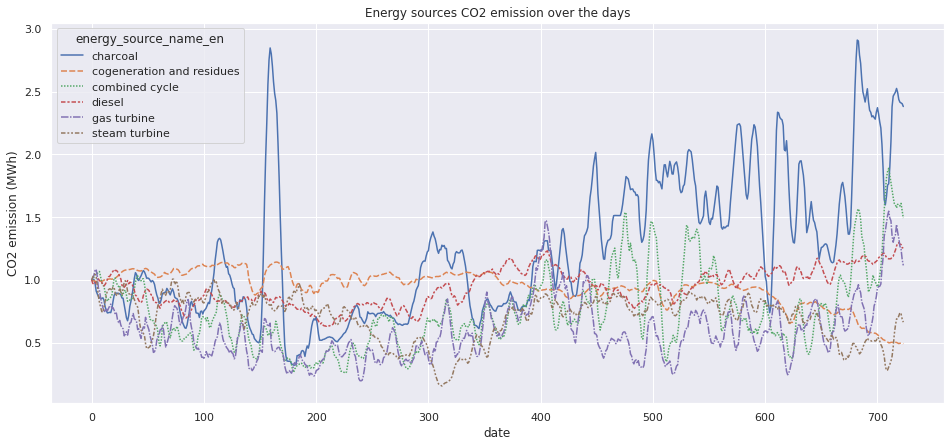

In [ ]:
fig_dims = (16,7)
fig, ax = plt.subplots(figsize = fig_dims)
ax.set(xlabel='date', ylabel='CO2 emission (MWh)')
sns.set(rc = {'figure.figsize':(12,8)})
sns.lineplot(data = nonrenew).set(title='Energy sources CO2 emission over the days')

The emission graph has the same shape than the generation one. We can also see the same peak on January 13th 2021.

## Query 5

In [ ]:
query_job = """
SELECT
  gen.date,
  gen.month,
  CASE
    WHEN gen.month < 4 THEN 'winter'
    WHEN gen.month < 7 THEN 'spring'
    WHEN gen.month < 10 THEN 'summer'
  ELSE
  'autumn'
END
  AS season,
  CASE
    WHEN gen.date < '2021-08-01' THEN '20-21'
  ELSE
  '21-22'
END
  AS year,
  gen.generation,
  em.emission,
  tm.energy_source_name_en,
  tm.energy_source_class_1
FROM (
  SELECT
    SUM(generation) AS generation,
    date,
    energy_source_id,
    EXTRACT(month
    FROM
      date) AS month
  FROM
    `energy-ree-project.energy_generic_info.energy-generation-ree`
  GROUP BY
    2,
    3) AS gen
LEFT JOIN (
  SELECT
    SUM(emission) AS emission,
    date,
    energy_source_id,
    EXTRACT(month
    FROM
      date) AS month
  FROM
    `energy-ree-project.energy_generic_info.co2-emission-ree`
  GROUP BY
    2,
    3) AS em
ON
  gen.date = em.date
  AND gen.energy_source_id = em.energy_source_id
LEFT JOIN
  `energy-ree-project.energy_generic_info.dim-basic-energy-data` AS tm
ON
  gen.energy_source_id = tm.energy_source_id;"""

query5 = pd.read_gbq(query_job, project_id=project_id, credentials = credentials, dialect='standard')

In [ ]:
query5.head()

,date,month,season,year,generation,emission,energy_source_name_en,energy_source_class_1
0,2020-08-01,8,summer,20-21,1568039.0,0.0,wind,renewable energy
1,2020-08-02,8,summer,20-21,2204108.0,0.0,wind,renewable energy
2,2020-08-03,8,summer,20-21,1820532.0,0.0,wind,renewable energy
3,2020-08-04,8,summer,20-21,1518641.0,0.0,wind,renewable energy
4,2020-08-05,8,summer,20-21,799306.0,0.0,wind,renewable energy


This query shows the generation and emission with a granularity by day, month, season and year with the energy source and the energy source class.

I will answer the following question regarding the generation and emission of the different energy sources through seasons:
*  Which energy source is the one that contaminates the most? And the less? Conduct the same observation over the seasons and compare the results.


The next question will be answered with the resulting table of the fifth query. Therefore, I'll do a little previous analysis of this query.

In [ ]:
# Check how many columns and attributes the data set has
query5.shape

(9490, 8)

In [ ]:
# Checking the name of the columns
query5.columns

Index(['date', 'month', 'season', 'year', 'generation', 'emission',
       'energy_source_name_en', 'energy_source_class_1'],
      dtype='object')

In [ ]:
# It's possible to see similar values on 'Real', 'Expected' and 'Scheduled' variable
query5.describe()

,month,generation,emission
count,9490.000000,9.490000e+03,9.490000e+03
mean,6.526027,6.584747e+05,9.218177e+04
std,3.448033,8.184666e+05,2.037858e+05
min,1.000000,-2.720450e+05,0.000000e+00
25%,4.000000,5.358325e+04,0.000000e+00
50%,7.000000,2.320970e+05,0.000000e+00
75%,10.000000,1.022897e+06,5.806525e+04
max,12.000000,5.072109e+06,1.808608e+06


In [ ]:
# Since the data was previously cleaned, there are no missing values
query5.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9490 entries, 0 to 9489
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   9490 non-null   dbdate 
 1   month                  9490 non-null   Int64  
 2   season                 9490 non-null   object 
 3   year                   9490 non-null   object 
 4   generation             9490 non-null   float64
 5   emission               9490 non-null   float64
 6   energy_source_name_en  9490 non-null   object 
 7   energy_source_class_1  9490 non-null   object 
dtypes: Int64(1), dbdate(1), float64(2), object(4)
memory usage: 602.5+ KB


## Which energy source is the one that contaminates the most? And the less? Conduct the same observation over the seasons and compare the results.

In [ ]:
# Filter by non renewable energies and group by energy source
nonrenew = query5[query5['energy_source_class_1'] == 'non renewable energy']
gbsource = nonrenew.groupby('energy_source_name_en').sum()
gbsource = gbsource.reset_index()
gbsource = gbsource.drop('month', axis = 1)

# Create the ratio column and order by its value
gbsource['ratio'] = gbsource['emission']/gbsource['generation']
gbsource.sort_values('ratio', ascending = False, inplace = True)
gbsource

,energy_source_name_en,generation,emission,ratio
5,gas turbine,1.128524e+07,1.162553e+07,1.030154
1,charcoal,1.443254e+08,1.375699e+08,0.953192
6,steam turbine,2.915447e+07,2.625038e+07,0.900389
0,auxiliar generation,2.412390e+05,1.642016e+05,0.680659
4,diesel,5.504916e+07,3.743325e+07,0.679997
3,combined cycle,1.227361e+09,4.764752e+08,0.388211
2,cogeneration and residues,6.623043e+08,1.852865e+08,0.279760


In [ ]:
# Group by season
gbseason = nonrenew.groupby(['season','energy_source_name_en']).sum()
gbseason = gbseason.reset_index()
gbseason = gbseason.drop('month', axis = 1)

# Create the ratio column and order by its value
gbseason['ratio'] = gbseason['emission']/gbseason['generation']
gbseason.sort_values('ratio', ascending = False, inplace = True)
gbseason

,season,energy_source_name_en,generation,emission,ratio
5,autumn,gas turbine,2482318.0,2.619569e+06,1.055291
26,winter,gas turbine,2233922.0,2.329743e+06,1.042893
12,spring,gas turbine,2554505.0,2.626355e+06,1.028127
19,summer,gas turbine,4014490.0,4.049864e+06,1.008812
1,autumn,charcoal,34803320.0,3.327154e+07,0.955988
15,summer,charcoal,33618849.0,3.209973e+07,0.954813
8,spring,charcoal,38838607.0,3.698639e+07,0.952310
22,winter,charcoal,37064657.0,3.521219e+07,0.950021
13,spring,steam turbine,5241876.0,4.721076e+06,0.900646
20,summer,steam turbine,7192083.0,6.475453e+06,0.900358


We can see that, except for one case or two, the ranking of the contaminating energy sources is the same depite the season.

## Query 6

In [ ]:
query_job = """
SELECT
  SUM(gen.generation) AS generation,
  SUM(em.emission) AS emission,
  tm.energy_source_name_en,
  tm.energy_source_class_1,
  SUM(SUM(gen.generation)) OVER(PARTITION BY tm.energy_source_class_1 ) AS source_class_total,
  SUM(gen.generation)*100/(SUM(SUM(gen.generation)) OVER(PARTITION BY tm.energy_source_class_1)) AS generation_percentage_by_class,
  SUM(em.emission)*100/(SUM(SUM(em.emission)) OVER ()) AS emission_percentage,
  SUM(gen.generation)*100/(SUM(SUM(gen.generation)) OVER ()) AS generation_percentage
FROM
  `energy-ree-project.energy_generic_info.energy-generation-ree` AS gen
LEFT JOIN
  `energy-ree-project.energy_generic_info.co2-emission-ree` AS em
ON
  gen.date = em.date
  AND gen.hour = em.hour
  AND gen.energy_source_id = em.energy_source_id
LEFT JOIN
  `energy-ree-project.energy_generic_info.dim-basic-energy-data` AS tm
ON
  gen.energy_source_id = tm.energy_source_id
GROUP BY
  tm.energy_source_name_en,
  tm.energy_source_class_1
ORDER BY
  energy_source_class_1;"""

query6 = pd.read_gbq(query_job, project_id=project_id, credentials = credentials, dialect='standard')

In [ ]:
query6.head()

,generation,emission,energy_source_name_en,energy_source_class_1,source_class_total,generation_percentage_by_class,emission_percentage,generation_percentage
0,5.504916e+07,3.743325e+07,diesel,non renewable energy,2.129721e+09,2.584806,4.279039,0.880938
1,6.623043e+08,1.852865e+08,cogeneration and residues,non renewable energy,2.129721e+09,31.098169,21.180324,10.598693
2,1.227361e+09,4.764752e+08,combined cycle,non renewable energy,2.129721e+09,57.630143,54.466453,19.641163
3,1.128524e+07,1.162553e+07,gas turbine,non renewable energy,2.129721e+09,0.529893,1.328928,0.180595
4,2.915447e+07,2.625038e+07,steam turbine,non renewable energy,2.129721e+09,1.368933,3.000712,0.466552


This query shows the percentages of generation and emission for each energy source over its energy source class. 

I will answer the following question regarding the percentages of generation and emission of the different energy sources over their energy source class:
*  Create a ranking with the generation and emission percentage of every source. Do that ranking first with the renewable and non renewable sources, later with every source with its kind and finally over the overall.

The next questions will be answered with the resulting table of the sixth query. Therefore, I'll do a little previous analysis of this query.

In [ ]:
query6.shape

(13, 8)

In [ ]:
query6.columns

Index(['generation', 'emission', 'energy_source_name_en',
       'energy_source_class_1', 'source_class_total',
       'generation_percentage_by_class', 'emission_percentage',
       'generation_percentage'],
      dtype='object')

In [ ]:
query6.describe()

,generation,emission,source_class_total,generation_percentage_by_class,emission_percentage,generation_percentage
count,1.300000e+01,1.300000e+01,1.300000e+01,13.000000,13.000000,13.000000
mean,4.806865e+08,6.729269e+07,3.047944e+09,15.384615,7.692308,7.692308
std,5.375517e+08,1.365170e+08,1.032291e+09,18.071794,15.605423,8.602307
min,2.412390e+05,0.000000e+00,2.129721e+09,0.011327,0.000000,0.003860
25%,5.504916e+07,0.000000e+00,2.129721e+09,2.584806,0.000000,0.880938
50%,1.443254e+08,1.642016e+05,2.129721e+09,6.776729,0.018770,2.309604
75%,6.623043e+08,3.743325e+07,4.119203e+09,31.098169,4.279039,10.598693
max,1.435096e+09,4.764752e+08,4.119203e+09,57.630143,54.466453,22.965481


In [ ]:
# Since the data was previously cleaned, there are no missing values
query6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   generation                      13 non-null     float64
 1   emission                        13 non-null     float64
 2   energy_source_name_en           13 non-null     object 
 3   energy_source_class_1           13 non-null     object 
 4   source_class_total              13 non-null     float64
 5   generation_percentage_by_class  13 non-null     float64
 6   emission_percentage             13 non-null     float64
 7   generation_percentage           13 non-null     float64
dtypes: float64(6), object(2)
memory usage: 960.0+ bytes


## Create a ranking with the generation and emission percentage of every source. Do that ranking first with the renewable and non renewable sources, later with every source with its kind and finally over the overall.

[Text(0.5, 1.0, 'Renewable and non renewable sources generation percentage')]

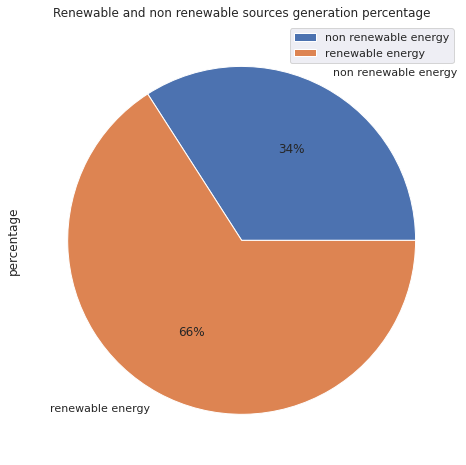

In [ ]:
# Group by the energy source class
sources = query6.groupby('energy_source_class_1').sum()
sources = sources.filter(['energy_source_class_1','generation'])
sources['percentage'] = sources['generation']*100/sources['generation'].sum()
sources.drop('generation', axis = 1, inplace = True)
sources = sources.reset_index()
sources.groupby(['energy_source_class_1']).sum().plot(kind='pie', y='percentage', autopct='%1.0f%%').set(title='Renewable and non renewable sources generation percentage')

In these two years, 66% of the energy has been generated through renewable energy sources.

In [ ]:
# Filter by non renewable energy sources
nonrenew = query6[query6['energy_source_class_1'] == 'non renewable energy']

# Filter by the columns I am interested in
nonrenew = nonrenew.filter(['energy_source_name_en','generation_percentage_by_class','emission_percentage'])
nonrenew.sort_values('generation_percentage_by_class', ascending = False, inplace = True)

# Round the percentages to two decimals
nonrenew = nonrenew.round(2)
nonrenew.rename(columns = {'energy_source_name_en':'energy source','generation_percentage_by_class':'generation percentage','emission_percentage':'emission percentage'}, inplace = True)
nonrenew

,energy source,generation percentage,emission percentage
2,combined cycle,57.63,54.47
1,cogeneration and residues,31.10,21.18
6,charcoal,6.78,15.73
0,diesel,2.58,4.28
4,steam turbine,1.37,3.00
3,gas turbine,0.53,1.33
5,auxiliar generation,0.01,0.02


[Text(20.200000000000003, 0.5, 'percentage'),
 Text(0.5, 20.200000000000003, 'energy source')]

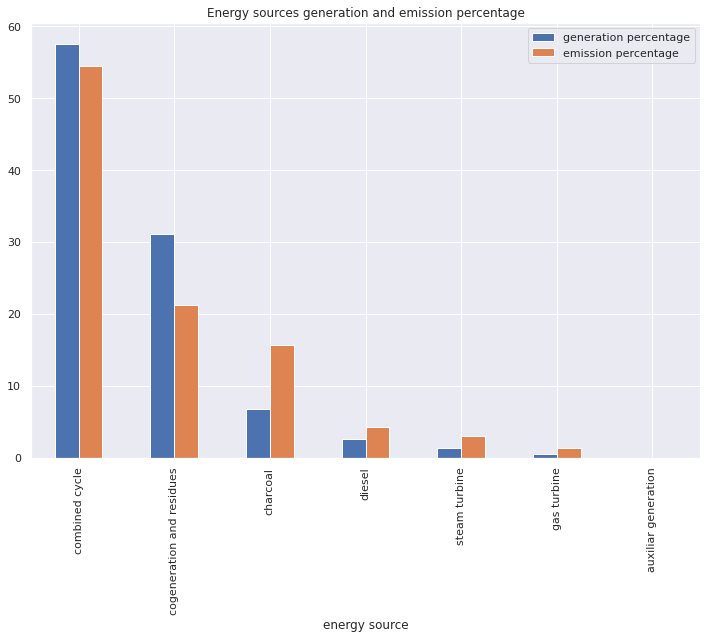

In [ ]:
nonrenew.plot(x = 'energy source', y = ['generation percentage','emission percentage'], kind = 'bar').set(title='Energy sources generation and emission percentage')
ax.set(xlabel='energy source', ylabel='percentage')

In the percentages of non renewable energy you can see some correlation between generation and emission.

In [ ]:
# Filter by renewable energy sources
renew = query6[query6['energy_source_class_1'] == 'renewable energy']

# Filter by the columns I am interested in
renew = renew.filter(['energy_source_name_en','generation_percentage_by_class'])
renew.sort_values(by = 'generation_percentage_by_class', ascending = False, inplace = True)

# Round the percentages to two decimals
renew = renew.round(2)
renew

,energy_source_name_en,generation_percentage_by_class
7,wind,34.84
9,nuclear,32.46
10,hydropower,14.22
12,photovoltaic solar,12.98
8,renewable thermal,2.85
11,thermal solar,2.66


Since renewable energy sources emit no CO2 the emission percentage of all of them is zero. It is surprising to see that the top position is for wind energy. It makes sense due to the enormous wind farms you can find around Spain. 
The next link shows a news about the wind energy and wind farms in Spain and its way of creating a more sustainable energetic system.
https://aeeolica.org/la-eolica-alcanza-los-28-138-mw-instalados-y-reclama-acelerar-su-desarrollo-como-solucion-hacia-un-nuevo-modelo-economico-y-energetico-que-minimice-la-dependencia-del-exterior%EF%BF%BC/#:~:text=Durante%202021%2C%20las%20comunidades%20aut%C3%B3nomas,(43%2C5%20MW)

## Conclusions

These are the main conclusions extracted from the EDA. There is also one bullet point for each one of the questions I have previously asked.

How is the evolution of the demand through the years? And through the day?
*   People consume more energy during the workweek and less energy on the weekend. 
Also, the time of maximum energy consumption is at lunchtime and dinnertime.
*   We can see a very high peak on demand on January 13th 2021. I searched for the news of that day and found that there was an increase of the electricity price. This is the link of the news [here]https://www.elcorreo.com/economia/tu-economia/subida-afecta-20210114122658-nt.html?ref=https%3A%2F%2Fwww.elcorreo.com%2Feconomia%2Ftu-economia%2Fsubida-afecta-20210114122658-nt.html):

Does exist a trend in the behaviour between the year 20-21 and 21-22?
*   When we compare the demand of the two different years we can see that the two graphics have a big correlation, except in April. The differences between those graphics in April are due to Eastern.

Which month of the year has the highest consumption? Does the consumption trend change over the seasons?
*   The months with the highest demand are January, July, August and December, the ones with the most extreme temperatures and more holidays. So are the seasons: Winter and Summer. Both in summer and winter, the energy consumption during the day is pretty similar, but in the afternoon, the consumption in winter starts earlier. This is due to the fewer hours of light.

Does a correlation exist between the real demand and the expected one?
*   There is a very strong correlation between the real demand and the expected one. This correlation is present even comparing by months or hours.

Which ones are the days with higher consumption than the average? Is there any relationship among them?
*  The relationship between these days is that, most of them are on workdays, very few are on weekend.

Does a correlation exist among generation, emission and demand?
*   There is a strong correlation between generation and demand, but not that strong between emission and demand.

Which season has the highest demand, generation and emission?
*  Both demand, generation and emission have Summer as the season with highest values, followed by Winter.

How is the evolution of the generation and emission through time? And through the day? And in 20-21 and 21-22?
*  Through time we can see certain similarities in the shape of generation and emission. The interesting behavior is found when compared through the day. 

How is the evolution of the renewable energies generation during the day?
*  When we plot the generation and the emission during the day, we see a difference in these trends. That difference is due to the activation of the renewable energy sources (mainly wind energy, hydropower and photovoltaic solar) which are more active during the hours where the emission decreases despite the generation increases.

Which energy source is the one that contaminates the most? And the less?
*   When we compare the ratio of emission over generation of the different non renewable energy sources, we see that the one that contaminates the most is the combined cycle. When we compare this trend for the different seasons, we see no differences in it. The different energy sources have the same ratio despite the season.

Create a ranking with the generation and emission percentage of every source.
*   For the renewable energy sources wind energy is the one that produces the highest amount of energy. This is due to the wind farms that are scattered around Spain. The next link shows news about the wind energy and wind farms in Spain and its way of creating a more sustainable energetic system. 
https://aeeolica.org/la-eolica-alcanza-los-28-138-mw-instalados-y-reclama-acelerar-su-desarrollo-como-solucion-hacia-un-nuevo-modelo-economico-y-energetico-que-minimice-la-dependencia-del-exterior%EF%BF%BC/#:~:text=Durante%202021%2C%20las%20comunidades%20aut%C3%B3nomas,(43%2C5%20MW). 








 




